In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15227512157399659957
]


In [27]:
"""
Build RBG Graph
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 79
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)


In [28]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb'
imagenet_pretrained = True
print("wiener")
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                print("pretrained")
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
pretrained
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
Norm of logits: 87.108871

Top classes and probabilities
0.9999968 25.856646 playing cricket
1.335354e-06 12.330335 playing kickball
4.553142e-07 11.254371 catching or throwing baseball
3.1434254e-07 10.883866 shooting goal (soccer)
1.9243305e-07 10.393131 catching or throwing softball
1.309655e-07 10.008317 throwing discus
1.0681848e-07 9.804514 javelin throw
9.446425e-08 9.681604 golf putting
7.842931e-08 9.49558 jogging
7.801767e-08 9.490318 hitting baseball
6.608518e-08 9.3243265 triple jump
3.4878482e-08 8.685253 hurling (sport)
2.996574e-08 8.533437 skateboarding
2.1083935e-08 8.181894 hurdling
2.0079328e-08 8.133075 playing tennis
1.8454037e-08 8.048665 breakdancing
1.7050859e-08 7.969584 hammer throw
1.7004545e-08 7.9668636 shot put
1.4611408e-08 7.8

In [34]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    start = time.time()
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    print("Blur time", time.time()-start)
    return X

def create_class_visualization(sess, target_y, logits, rgb_input, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)

    X = np.random.rand(num_frames, 224, 224, 3)
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            plt.imshow(X[0][0])
            
            #class_name = class_names[target_y]
            
            class_name = "temp"
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, 6, model_logits, rgb_input, num_iterations=1000)

Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt


InvalidArgumentError: Cannot assign a device for operation 'gradients/RGB/inception_i3d/Mean_grad/Prod_1': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: gradients/RGB/inception_i3d/Mean_grad/Prod_1 = Prod[T=DT_INT32, Tidx=DT_INT32, keep_dims=false, _device="/device:GPU:0"](gradients/RGB/inception_i3d/Mean_grad/Shape_3, gradients/RGB/inception_i3d/Mean_grad/Const_1)]]

Caused by op 'gradients/RGB/inception_i3d/Mean_grad/Prod_1', defined at:
  File "/Users/wsong/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/wsong/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-1dc3b91f03e8>", line 8, in <module>
    create_class_visualization(sess, 6, model_logits, rgb_input, num_iterations=1000)
  File "<ipython-input-5-016fd445665d>", line 48, in create_class_visualization
    grad = tf.gradients(loss, rgb_input)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 611, in gradients
    lambda: grad_fn(op, *out_grads))
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 377, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 611, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py", line 112, in _MeanGrad
    math_ops.reduce_prod(input_shape), math_ops.reduce_prod(output_shape))
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1562, in reduce_prod
    name=name))
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2979, in _prod
    name=name)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'RGB/inception_i3d/Mean', defined at:
  File "/Users/wsong/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-ea4b769da781>", line 34, in <module>
    rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/sonnet/python/modules/base.py", line 386, in __call__
    outputs, subgraph_name_scope = self._template(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 351, in __call__
    result = self._call_func(args, kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 302, in _call_func
    result = self._func(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/sonnet/python/modules/base.py", line 243, in _build_wrapper
    output = self._build(*args, **kwargs)
  File "/Users/wsong/mlab/kinetics-i3d/i3d.py", line 472, in _build
    averaged_logits = tf.reduce_mean(logits, axis=1)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 432, in new_func
    return func(*args, **kwargs)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1512, in reduce_mean
    name=name))
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2635, in _mean
    name=name)
  File "/Users/wsong/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'gradients/RGB/inception_i3d/Mean_grad/Prod_1': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: gradients/RGB/inception_i3d/Mean_grad/Prod_1 = Prod[T=DT_INT32, Tidx=DT_INT32, keep_dims=false, _device="/device:GPU:0"](gradients/RGB/inception_i3d/Mean_grad/Shape_3, gradients/RGB/inception_i3d/Mean_grad/Const_1)]]


Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
arm wrestling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
Blur time 0.0016651153564453125
iteration: 0 7.782408237457275


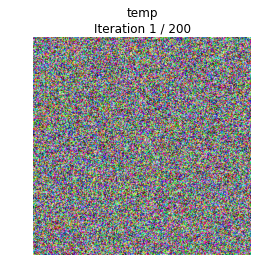

iteration: 1 12.588573217391968
iteration: 2 17.480334043502808
iteration: 3 22.728895902633667
Blur time 0.0016510486602783203
iteration: 4 27.520231246948242
iteration: 5 32.30052185058594
iteration: 6 37.53531312942505


In [ ]:
print(model_logits)
print(rgb_input)
class_id = 6
print(kinetics_classes[class_id])
with tf.device("/cpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # create_class_visualization(sess, y, model_logits, rgb_input, num_iterations=10, num_frames=1)
        create_class_visualization(sess, class_id, model_logits, rgb_input, num_iterations=200, num_frames=1, learning_rate=1.5, blur_every=4, max_jitter=32)